###**Building a simple GAN in Keras**

In [1]:
import keras
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from tqdm import tqdm

In [4]:
import numpy as np
np.random.seed(1000)
#Next we set the dimension of a random noise vector.
random_dim = 100

In [5]:
mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


((array([[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         ...,
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0

In [16]:
def load_minst_data():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train.astype(np.float32)
  x_train = (x_train - 127.5)/127.5
  x_train = x_train.reshape(60000, 784)
  return (x_train, y_train, x_test, y_test)

In [17]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

In [18]:
generator = Sequential()
generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

In [19]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

In [20]:
discriminator.trainable = False
ganInput = Input(shape=(random_dim,))

In [21]:
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [22]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
  noise = np.random.normal(0, 1, size=[examples, random_dim])
  generated_images = generator.predict(noise)
  generated_images = generated_images.reshape(examples, 28, 28)
  plt.figure(figsize=figsize)
  for i in range(generated_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
  plt.tight_layout()
  plt.savefig('image_generated_%d.png' % epoch)

In [32]:
def train(epochs=1, batch_size=128):
  x_train, y_train, x_test, y_test = load_minst_data()
  batch_count = x_train.shape[0] / batch_size
  for e in range(1, epochs+1):
    print('-'*10, 'Epoch %d' % e, '-'*10)
    for _ in tqdm(range(int(batch_count))):
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
      generated_images = generator.predict(noise)
      X = np.concatenate([image_batch, generated_images])
      y_dis = np.zeros(2*batch_size)
      y_dis[:batch_size] = 0.9
      discriminator.trainable = True
      discriminator.train_on_batch(X, y_dis)
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      y_gen = np.ones(batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y_gen)
                            
    plot_generated_images(e, generator)

  0%|          | 0/468 [00:00<?, ?it/s]

---------- Epoch 1 ----------


100%|██████████| 468/468 [01:24<00:00,  5.52it/s]


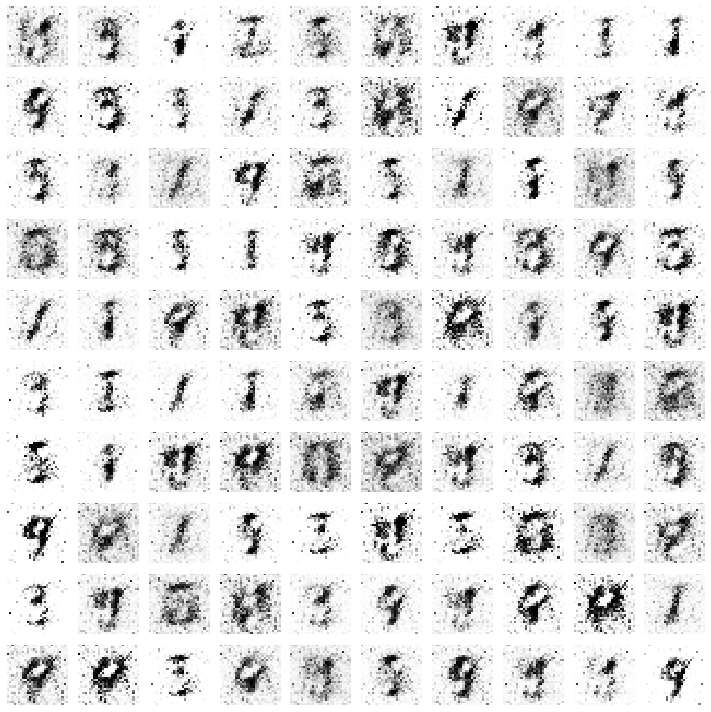

In [33]:
train(1, 128)

  0%|          | 1/468 [00:00<01:17,  6.05it/s]

---------- Epoch 1 ----------


  0%|          | 1/468 [00:00<01:16,  6.08it/s]

---------- Epoch 2 ----------


  0%|          | 1/468 [00:00<01:26,  5.41it/s]

---------- Epoch 3 ----------


  0%|          | 1/468 [00:00<01:17,  6.04it/s]

---------- Epoch 4 ----------


  0%|          | 1/468 [00:00<01:17,  5.99it/s]

---------- Epoch 5 ----------


  0%|          | 1/468 [00:00<01:14,  6.27it/s]

---------- Epoch 6 ----------


  0%|          | 1/468 [00:00<01:20,  5.80it/s]

---------- Epoch 7 ----------


  0%|          | 1/468 [00:00<01:18,  5.93it/s]

---------- Epoch 8 ----------


  0%|          | 1/468 [00:00<01:22,  5.65it/s]

---------- Epoch 9 ----------


  0%|          | 1/468 [00:00<01:28,  5.25it/s]

---------- Epoch 10 ----------


  0%|          | 1/468 [00:00<01:23,  5.61it/s]

---------- Epoch 11 ----------


  0%|          | 1/468 [00:00<01:18,  5.97it/s]

---------- Epoch 12 ----------


  0%|          | 1/468 [00:00<01:22,  5.66it/s]

---------- Epoch 13 ----------


  0%|          | 1/468 [00:00<01:29,  5.25it/s]

---------- Epoch 14 ----------


  0%|          | 1/468 [00:00<01:20,  5.78it/s]

---------- Epoch 15 ----------


  0%|          | 1/468 [00:00<01:18,  5.94it/s]

---------- Epoch 16 ----------


  0%|          | 1/468 [00:00<01:25,  5.44it/s]

---------- Epoch 17 ----------


  0%|          | 0/468 [00:00<?, ?it/s]

---------- Epoch 18 ----------


  0%|          | 0/468 [00:00<?, ?it/s]

---------- Epoch 19 ----------


  0%|          | 1/468 [00:00<01:25,  5.43it/s]

---------- Epoch 20 ----------


  0%|          | 1/468 [00:00<01:23,  5.57it/s]

---------- Epoch 21 ----------


100%|██████████| 468/468 [01:29<00:00,  5.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
  0%|          | 1/468 [00:00<01:23,  5.62it/s]

---------- Epoch 22 ----------


  0%|          | 1/468 [00:00<01:30,  5.17it/s]

---------- Epoch 23 ----------


  0%|          | 0/468 [00:00<?, ?it/s]

---------- Epoch 24 ----------


  0%|          | 0/468 [00:00<?, ?it/s]

---------- Epoch 25 ----------


100%|██████████| 468/468 [01:36<00:00,  4.84it/s]


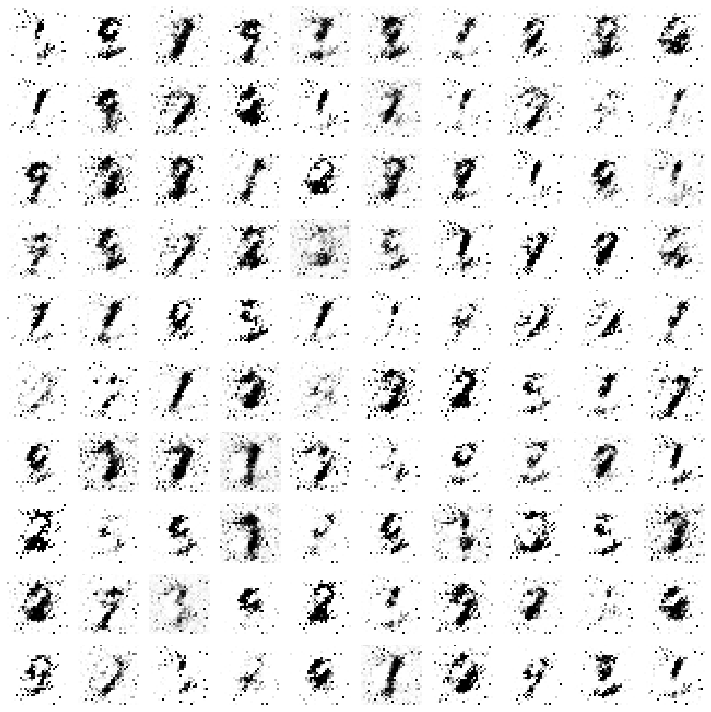

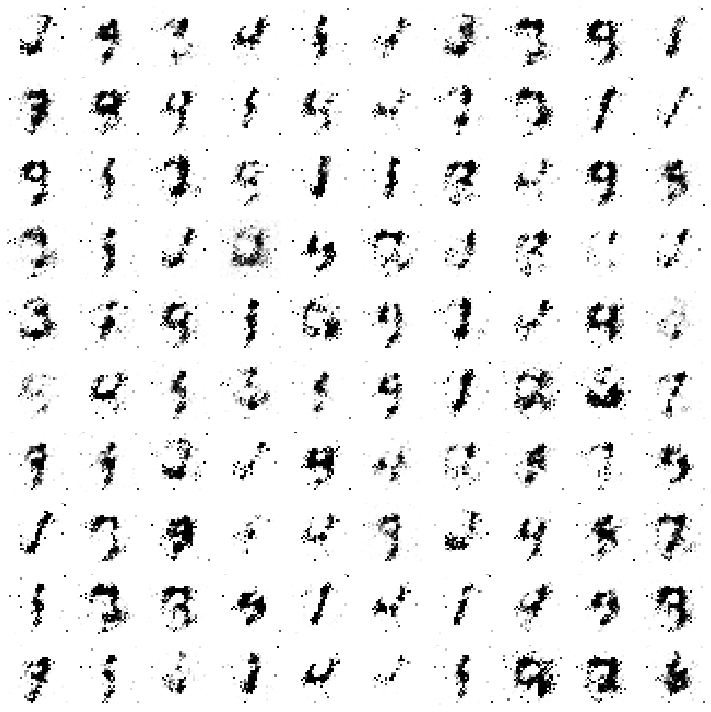

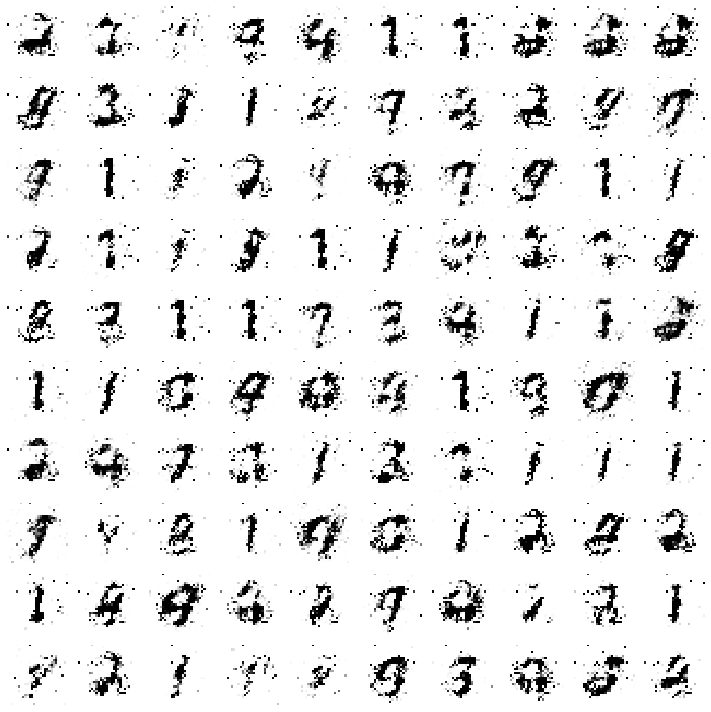

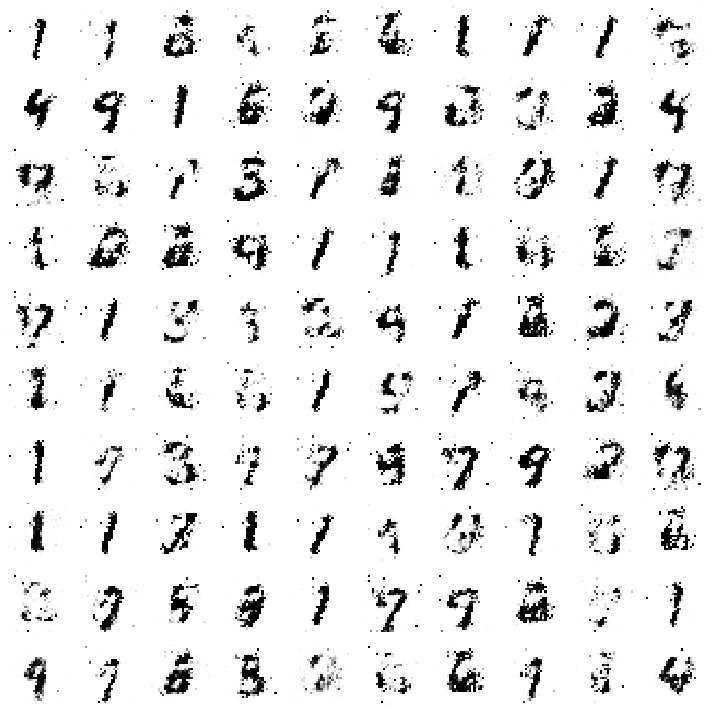

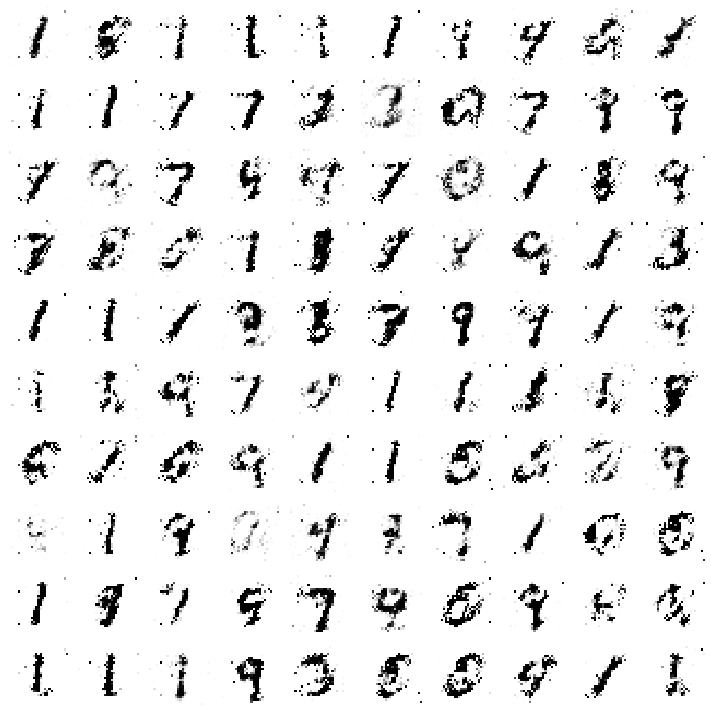

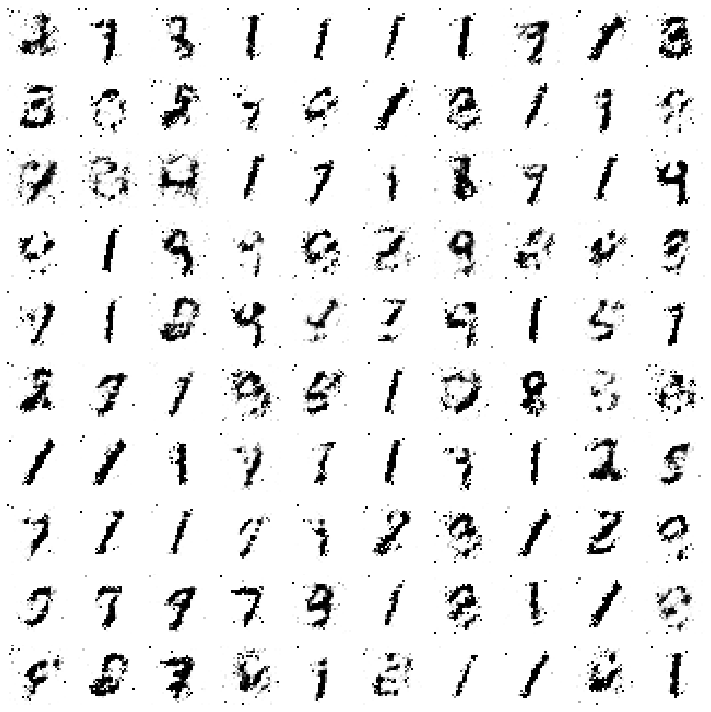

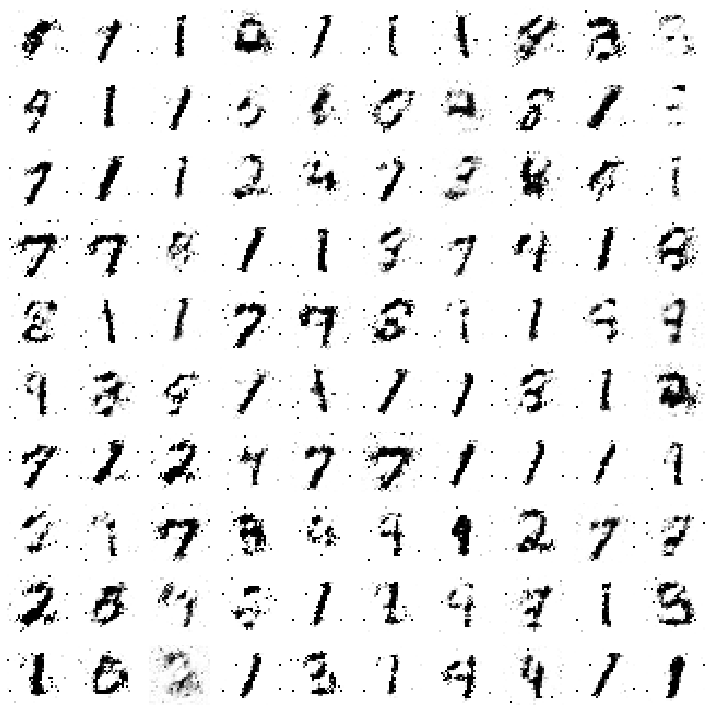

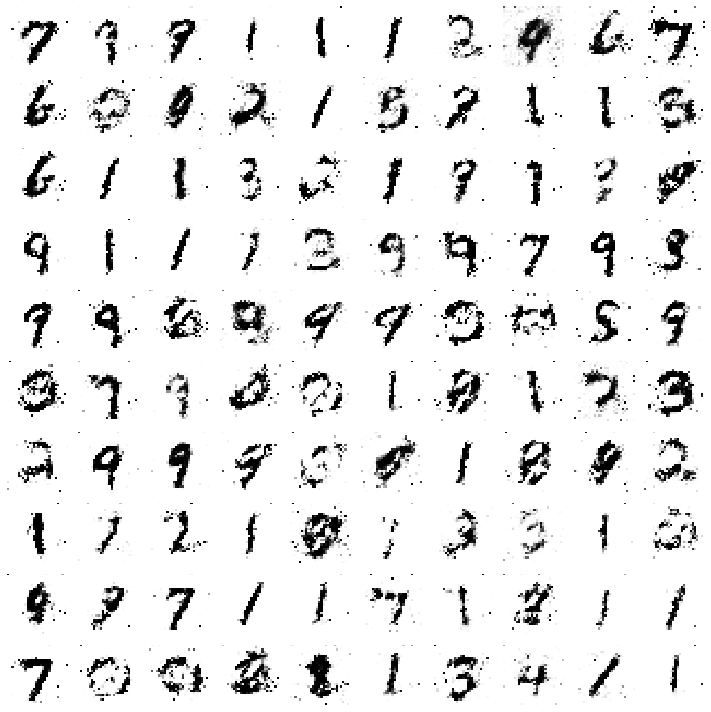

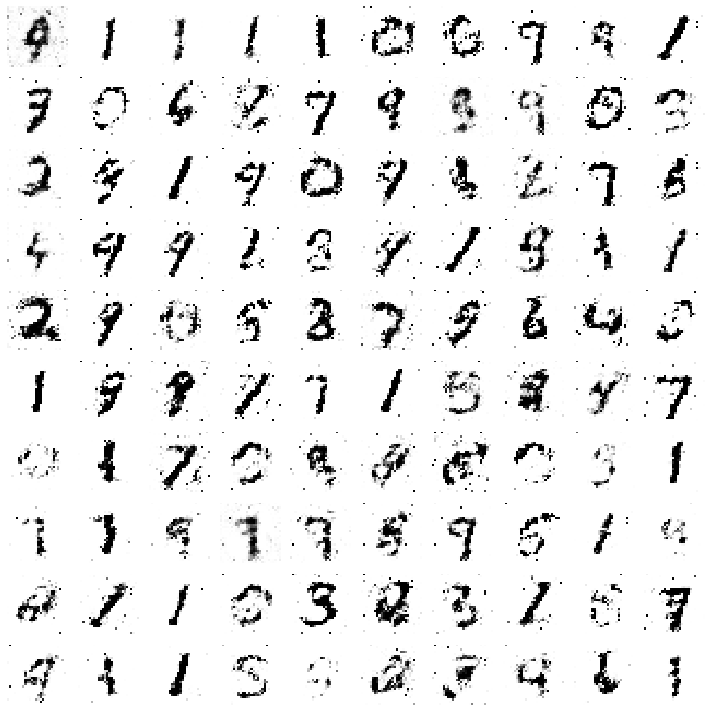

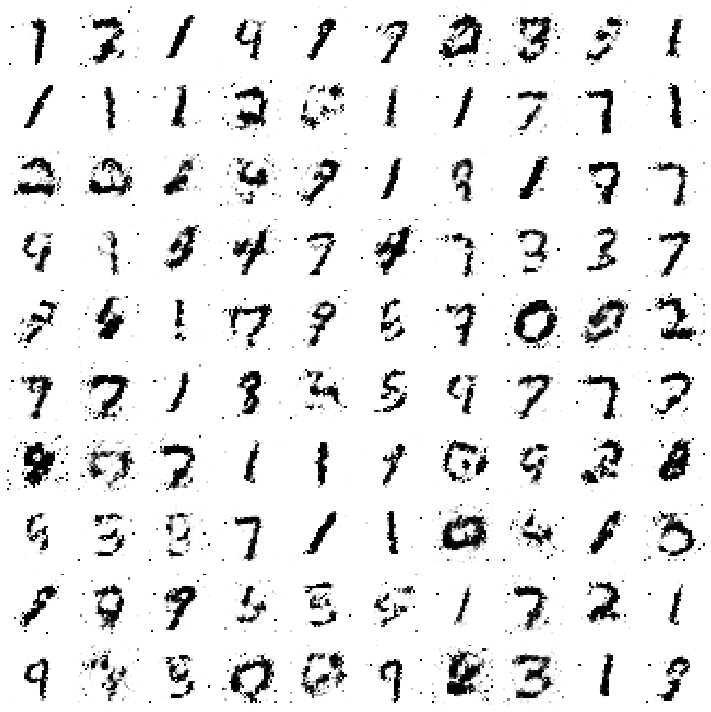

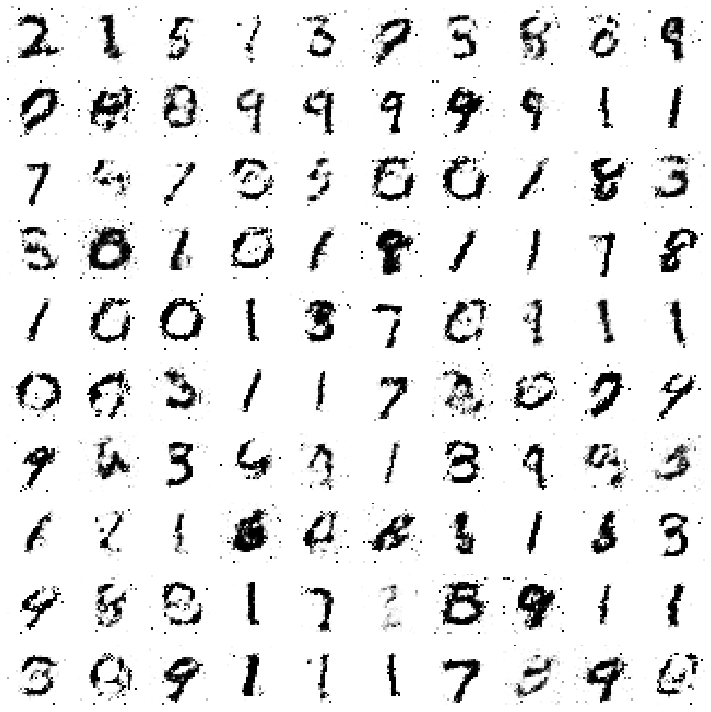

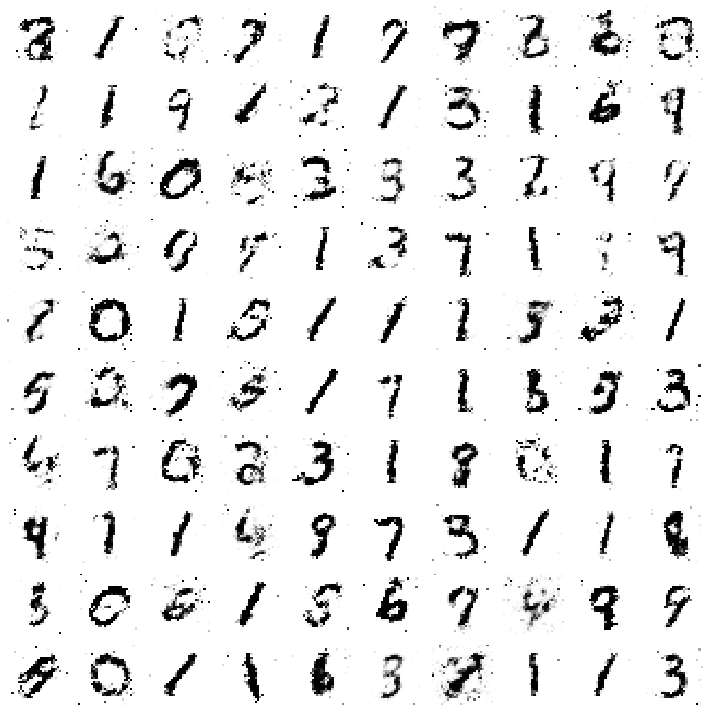

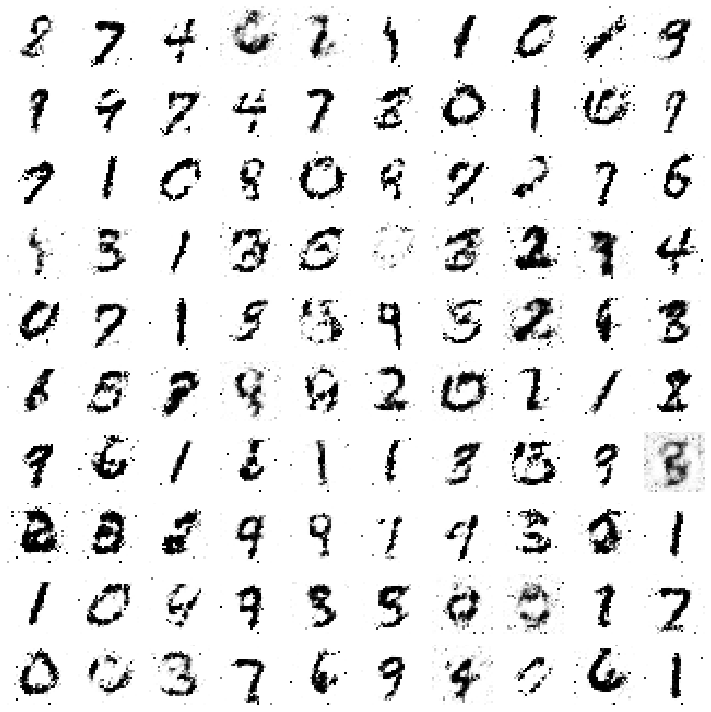

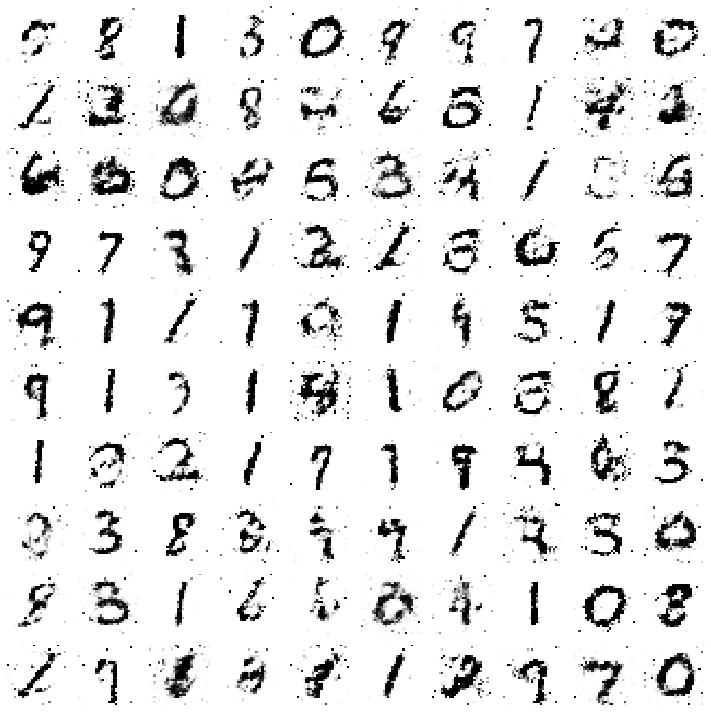

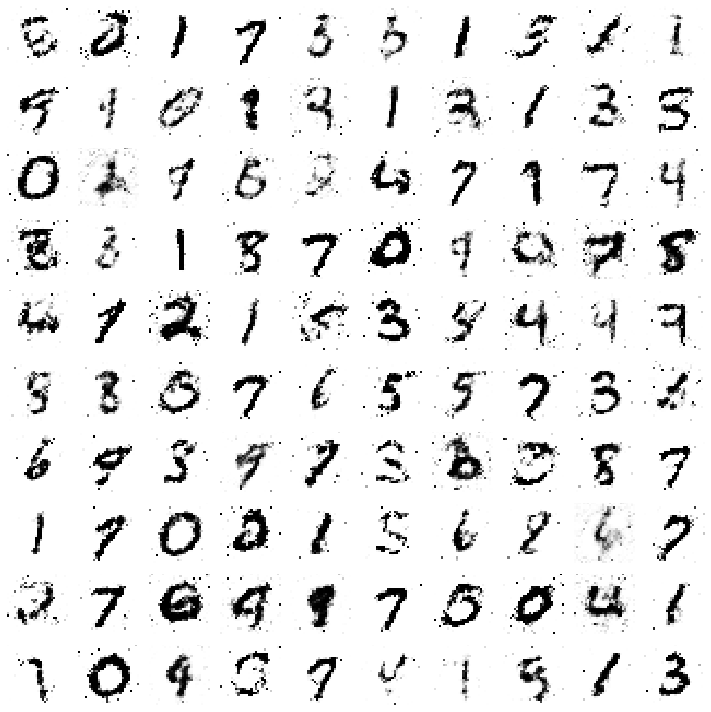

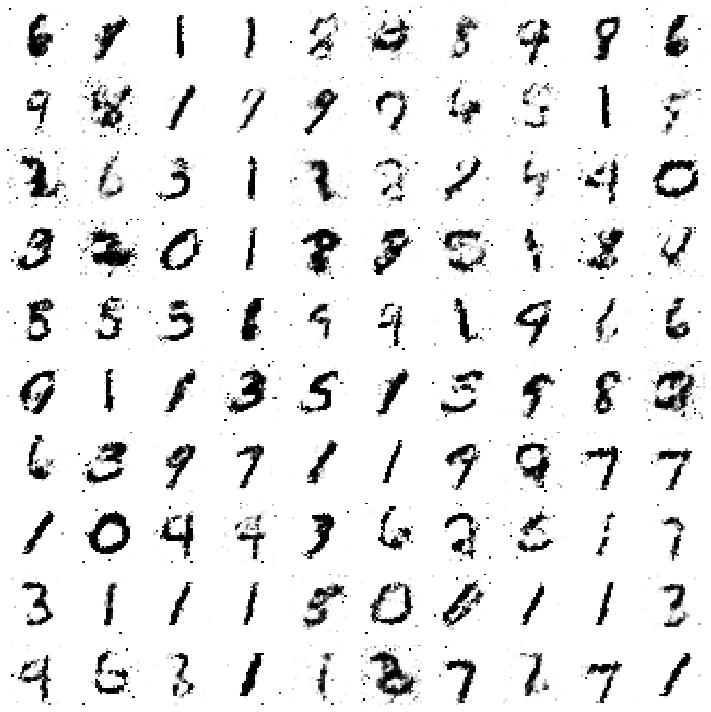

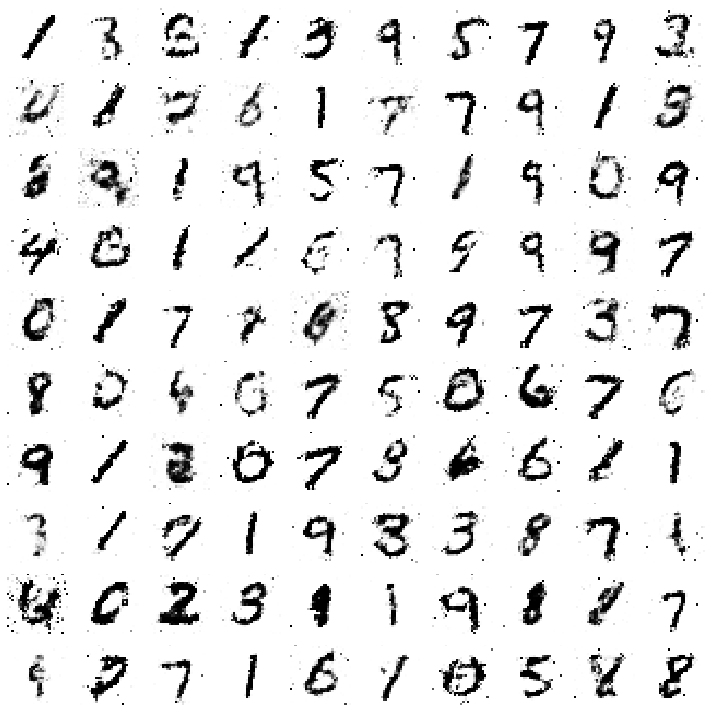

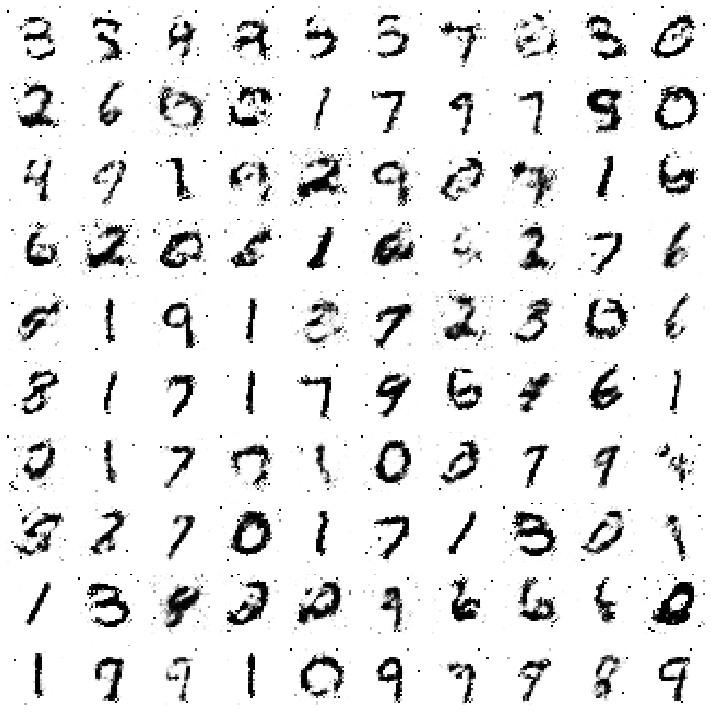

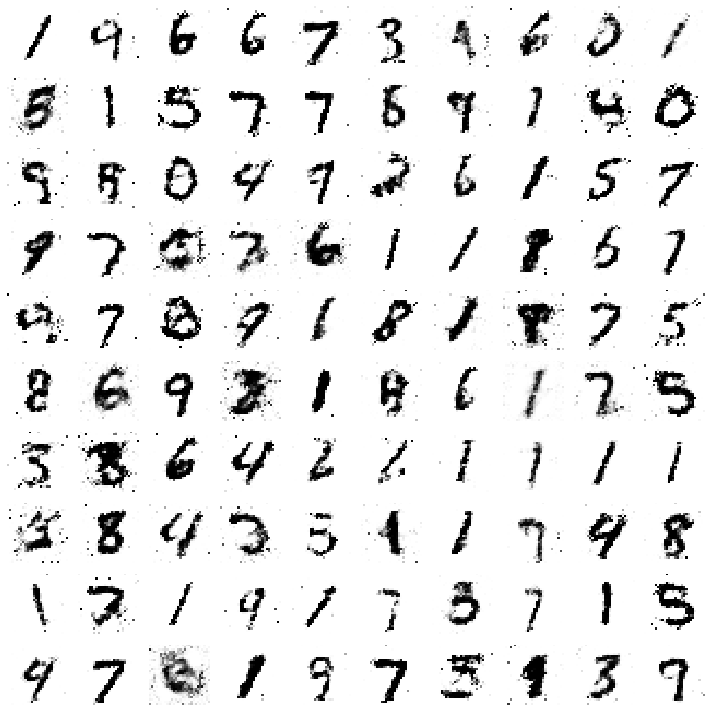

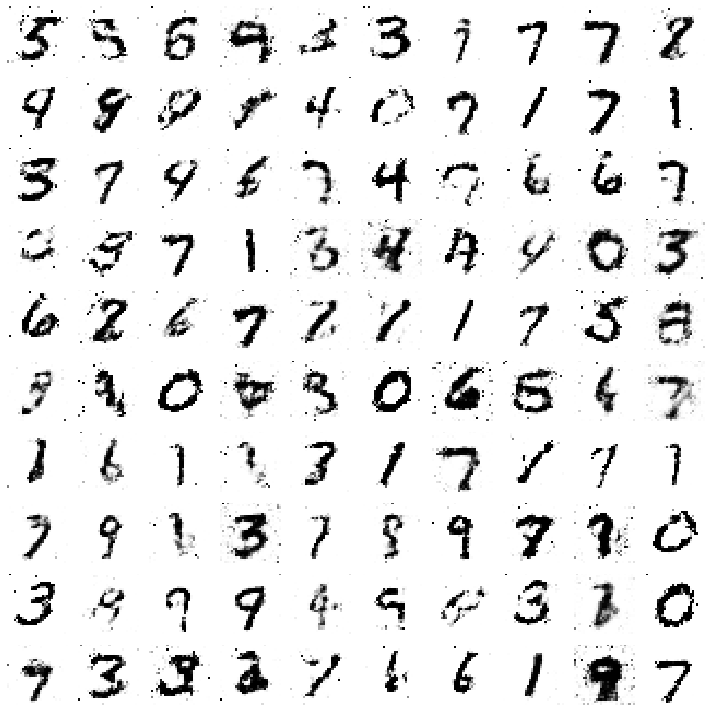

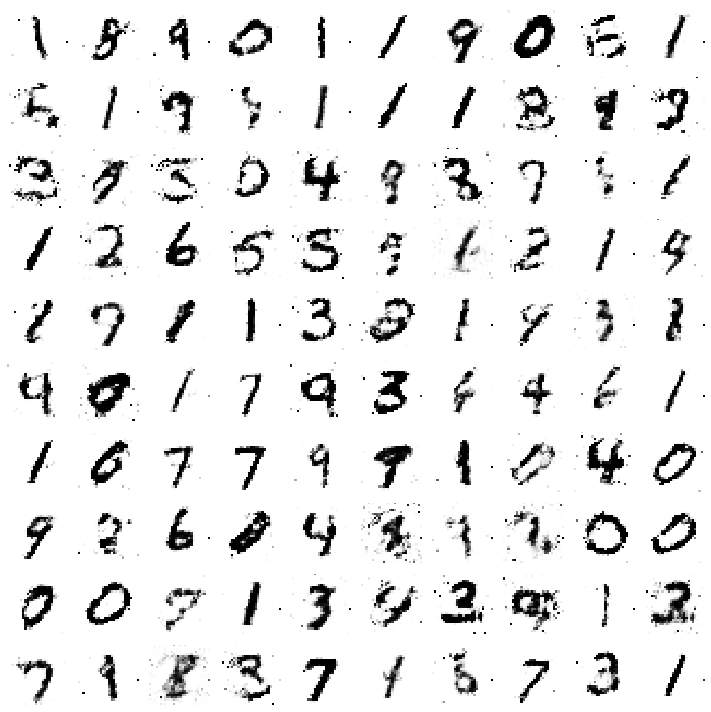

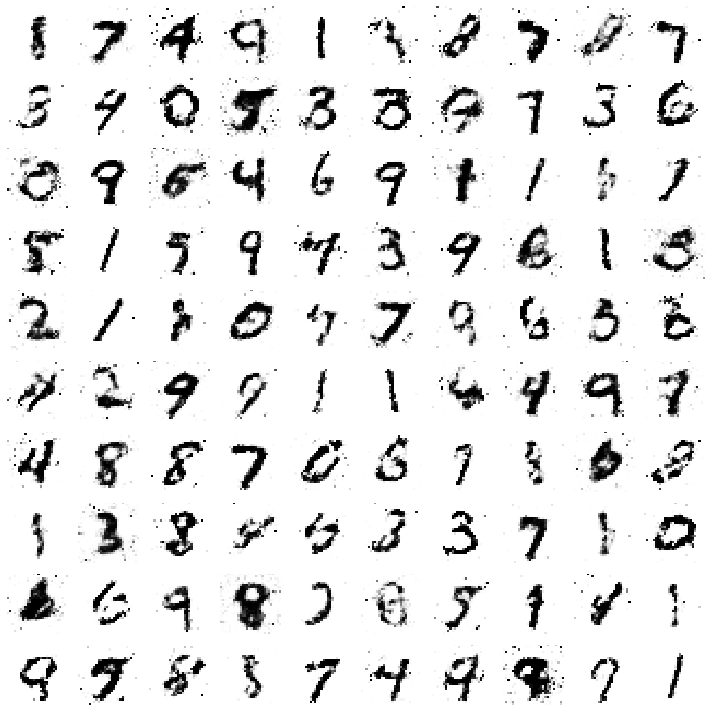

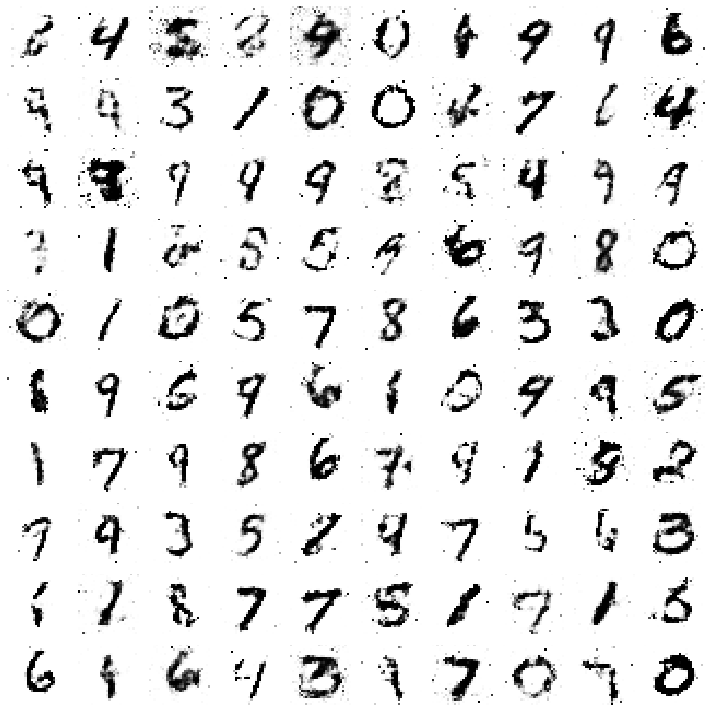

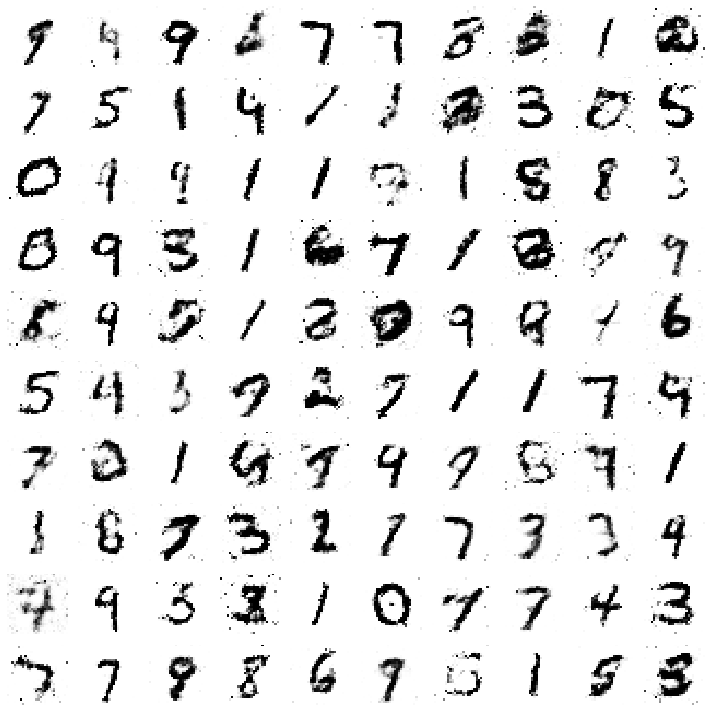

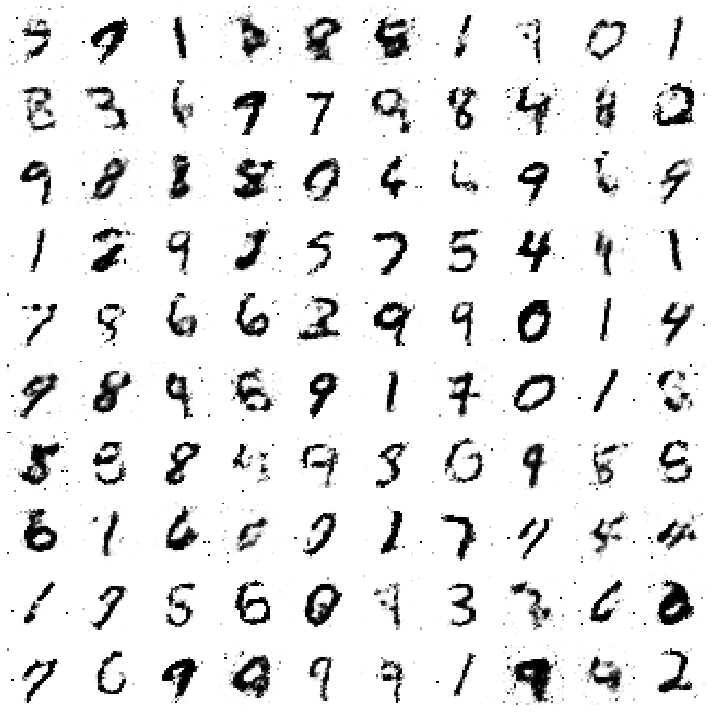

In [34]:
train(25, 128)